# Reproduction of figure 6: Dynamics of the occupancy profiles

In this notebook we describe how to generate fig 6 from the paper.


In [1]:
import math
import numpy as np
from pylab import *
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import os, os.path
#import functions as fct
import random
import glycogen_module as gm
import json
import random

In [2]:
with open("parameters.json", "r") as f:
    parameters = json.load(f) 

In [3]:
def Gillespie_step(structure, C):
    ''' This functions takes concentrations of the enzymes and the structure info of a glycogen granules and
    return what is the next reaction to occurs and which time has been spent. (Following a gillespie algorithm)
    '''
    #propensity assuming mass action kinetics
    h_gs = C["GS"]*len(structure.Find_chain_for_gs())
    h_gp = C["GP"]*len(structure.Find_chain_for_gp())
    h_gbe = C["GBE"]*len(structure.Find_chain_for_gbe())
    h_gde = C["GDE"]*len(structure.Find_chain_for_gde())
    
    a = h_gs + h_gp + h_gbe + h_gde
    
    if a == 0:
        return "no reaction can be proceed, all propensities are zero",0
    r2=random.uniform(0,a)    
    r1=random.uniform(0,1)	
    
    d_t = (1/a)*math.log(1/r1)
    if r2 < h_gs :
        return "Act_gs",d_t
    if r2 >= h_gs and r2 < h_gs + h_gp :
        return "Act_gp",d_t
    if r2 >=  h_gs + h_gp  and r2 < h_gs + h_gp + h_gbe :
        return "Act_gbe",d_t
    if r2 >=  h_gs + h_gp + h_gbe  and r2 < h_gs + h_gp + h_gbe + +h_gde:
        return "Act_gde",d_t   

## Generating the data

By default in this tutorial, N is set to 3,000 glucose units, with 5 simulations (approx computational time = 2min). In the paper, left and right panels have been obtained averaging 20 simulations each with N = 50,000 glucoses. (Approx 20 x 3 hours each on a single CPU).

In [4]:
Number_of_simulations = 5
path_of_local_folder = os.getcwd()


folder_name = '/data_for_densities'

os.mkdir(path_of_local_folder+folder_name)
data_path = path_of_local_folder+folder_name



parameters['b']=5.4

parameters['number_of_glucose_to_be_fixed'] = 3000
# in the paper, we plot occupancies every 1000 and 5000 glucoses units,
# For this example where N = 5000, we will plot the occupancy every 1000 units

snapchot_step = 500

parameters['size_spec_gbe_leftover'] = 3
parameters['size_spec_gbe_transferred'] = 3
parameters['size_spec_gbe_spacing'] = 1

C0 = {"GS":0.2,"GBE":1.0,"GP":0.00,"GDE":0.00} 

cond = 0
for k in range(Number_of_simulations):
    
    my_granule = gm.glycogen_structure(parameters, 2,1)

    N = my_granule.number_of_glucose_fixed()  
        

    while N <= parameters['number_of_glucose_to_be_fixed']:
        if N%5000 == 0:
            print('avancement = ', 100*N/parameters['number_of_glucose_to_be_fixed'], '%','   part 1/2')
            
        reaction, time = Gillespie_step(my_granule, C0)
        if reaction == 'Act_gs':
            my_granule.Act_gs()
        elif reaction == 'Act_gp' and N>10:
            my_granule.Act_gp()
        elif reaction == 'Act_gbe':
            my_granule.Act_gbe_flexible_model()
        elif reaction == 'Act_gde':
            my_granule.Act_gde()

        N = my_granule.number_of_glucose_fixed()
        if my_granule.number_of_glucose_fixed() % snapchot_step == 0:
            folder_path =data_path
            name = 'glycogen_structure'+str(my_granule.number_of_glucose_fixed())+'_'+str(k)+'.json'
            my_granule.write_structure(folder_path+'/'+name)

## Plotting the snapshots


<ipython-input-5-68d9d60b8403>:35: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('densityprofil.png',quality=95)


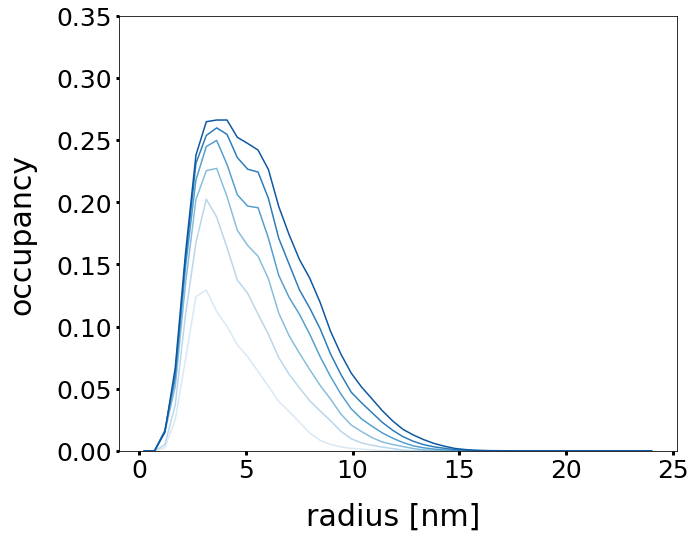

In [5]:
snapshots = [snapchot_step*(k+1) for k in range(int(parameters['number_of_glucose_to_be_fixed']/snapchot_step))]

total_occupancy = []
path_of_folder = os.getcwd()+'/data_for_densities'

#Averaging over simulations
for snapschot_value in snapshots:
    occupancy_list = []
    for i in range(Number_of_simulations):
        file_name='glycogen_structure'+str(snapschot_value)+'_'+str(i)+'.json'
        path=path_of_folder+'/'+file_name

        with open(path, "r") as f:
            my_granule_info = json.load(f)
        
        my_granule = gm.glycogen_structure(parameters)           
        my_granule.information = my_granule_info
        
        occupancy_list.append(my_granule.get_density_profile())
       
    total_occupancy.append(np.mean(occupancy_list,axis = 0))

#making the plot
cmap = plt.cm.Blues

colorbis=cmap(np.linspace(0.15, 0.85, len(total_occupancy)) )    
plt.figure(figsize=(10,8))
for i in range(len(total_occupancy)):
    #if i <=3:
    plt.plot(0.24*np.linspace(1,100,50),total_occupancy[i],color=colorbis[i])
plt.xlabel('radius [nm] ',fontsize='30',labelpad = 20)
plt.ylabel('occupancy',fontsize='30',labelpad = 20)
plt.tick_params(axis='both',width=3,labelsize=25)
plt.ylim([0,0.35])
plt.savefig('densityprofil.png',quality=95)
plt.show()